In [ ]:
# Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
from sqlalchemy import create_engine

from dotenv import load_dotenv
from catboost import CatBoostClassifier
import os
import gc
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Загружаем переменные окружения из .env файла
load_dotenv()

True

In [3]:
# Создаем URL для SQLAlchemy
SQLALCHEMY_DATABASE_URL = (
    f"postgresql://"
    f"{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@"
    f"{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/"
    f"{os.getenv('POSTGRES_DATABASE')}"
)
engine = create_engine(SQLALCHEMY_DATABASE_URL)
connection = engine.connect().execution_options(stream_results=True)

In [ ]:
# Данные по пользователям

user_info = pd.read_sql("""SELECT * FROM public.user_data""", con=connection)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [ ]:
# Посты и топики

posts_info = pd.read_sql(
    """SELECT * FROM posts_info_deep_features_ruslan_prashchurovich""", con=connection
)

posts_info.head()

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,12,3.803364,3.641078,3.503630,3.033075,2.276970,3.463066,3.508869,3.406232,3.463735,3.413809,2.417847,1.983550,1.912621,3.475528,2.879717
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,12,3.610889,3.381778,3.169918,2.885389,2.292614,3.320669,3.285646,3.387437,3.375190,3.364406,2.386165,2.246995,1.478820,3.019533,2.602994
2,3,Asian quake hits European shares\n\nShares in ...,business,12,3.647826,3.428573,3.177275,3.095651,3.101687,3.435107,3.458061,3.546807,3.416218,3.330880,2.493758,1.920925,1.855948,3.039433,2.946122
3,4,India power shares jump on debut\n\nShares in ...,business,11,3.133031,3.879746,3.885824,3.391752,3.506583,3.885024,4.156692,3.799252,3.836481,3.627957,2.957552,2.575662,2.617805,3.820382,3.488249
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,11,3.528582,3.251030,3.060982,2.880629,3.147450,3.021023,3.433394,3.007250,3.059660,3.250440,2.337950,1.870461,2.439339,2.901595,2.430091


In [ ]:
# Попробуем забрать, скажем, 9 миллионов

feed_data = pd.read_sql(
    """SELECT * FROM feed_data WHERE action = 'view' LIMIT 9000000""", con=connection
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-08 22:04:36,42882,2735,view,0
1,2021-12-08 22:07:34,42882,7030,view,0
2,2021-12-08 22:09:35,42882,5254,view,0
3,2021-12-08 22:11:55,42882,6703,view,1
4,2021-12-08 22:13:37,42882,4919,view,0


In [9]:
# Воспроизведем датафрейм со всеми новыми фичами
df = pd.merge(feed_data, posts_info, on="post_id", how="left")
df = pd.merge(df, user_info, on="user_id", how="left")

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-12-08 22:04:36,42882,2735,view,0,August 16 : Positive cases reported worldwide ...,covid,9,3.022972,2.280955,...,3.039004,3.507603,3.167144,1,22,Ukraine,Simferopol,0,Android,ads
1,2021-12-08 22:07:34,42882,7030,view,0,Two great stars and a legendary Director creat...,movie,5,2.315958,2.960218,...,3.097284,2.671299,2.013590,1,22,Ukraine,Simferopol,0,Android,ads
2,2021-12-08 22:09:35,42882,5254,view,0,There is a phrase by the experimental filmmake...,movie,7,2.597711,3.045479,...,3.129618,3.293925,2.402410,1,22,Ukraine,Simferopol,0,Android,ads
3,2021-12-08 22:11:55,42882,6703,view,1,This is part one of a short animation clip sho...,movie,7,2.814192,3.039721,...,3.282229,3.584455,2.751610,1,22,Ukraine,Simferopol,0,Android,ads
4,2021-12-08 22:13:37,42882,4919,view,0,Upon seeing this film once again it appeared i...,movie,7,2.434556,3.357298,...,3.631477,3.467985,2.620096,1,22,Ukraine,Simferopol,0,Android,ads


In [10]:
# А еще научимся выделять признаки из даты
df["hour"] = pd.to_datetime(df["timestamp"]).apply(lambda x: x.hour)
df["month"] = pd.to_datetime(df["timestamp"]).apply(lambda x: x.month)

# Циклическое кодирование
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,city,exp_group,os,source,hour,month,hour_sin,hour_cos,month_sin,month_cos
0,2021-12-08 22:04:36,42882,2735,view,0,August 16 : Positive cases reported worldwide ...,covid,9,3.022972,2.280955,...,Simferopol,0,Android,ads,22,12,-0.5,0.866025,-2.449294e-16,1.0
1,2021-12-08 22:07:34,42882,7030,view,0,Two great stars and a legendary Director creat...,movie,5,2.315958,2.960218,...,Simferopol,0,Android,ads,22,12,-0.5,0.866025,-2.449294e-16,1.0
2,2021-12-08 22:09:35,42882,5254,view,0,There is a phrase by the experimental filmmake...,movie,7,2.597711,3.045479,...,Simferopol,0,Android,ads,22,12,-0.5,0.866025,-2.449294e-16,1.0
3,2021-12-08 22:11:55,42882,6703,view,1,This is part one of a short animation clip sho...,movie,7,2.814192,3.039721,...,Simferopol,0,Android,ads,22,12,-0.5,0.866025,-2.449294e-16,1.0
4,2021-12-08 22:13:37,42882,4919,view,0,Upon seeing this film once again it appeared i...,movie,7,2.434556,3.357298,...,Simferopol,0,Android,ads,22,12,-0.5,0.866025,-2.449294e-16,1.0


In [11]:
# Уберем все ненужные колонки

df = df.drop(
    columns=[
        #    'timestamp',  # timestamp пока оставим
        "action",
        "text",
    ],
    axis=1,
)

In [12]:
# Почистим переменные

del user_info
del posts_info
del feed_data

gc.collect()

0

In [13]:
# За отсечку возьмем 2021-12-10

X_train = df[df.timestamp < "2021-12-10"].drop(
    columns=["timestamp", "target", "user_id", "post_id"], axis=1
)
X_test = df[df.timestamp >= "2021-12-10"].drop(
    columns=["timestamp", "target", "user_id", "post_id"], axis=1
)

y_train = df[df.timestamp < "2021-12-10"]["target"]
y_test = df[df.timestamp >= "2021-12-10"]["target"]

y_train.shape, y_test.shape

((7022750,), (1977250,))

In [14]:
object_cols = [
    "topic",
    "TextCluster",
    "gender",
    "country",
    "city",
    "exp_group",
    "hour",
    "month",
    "os",
    "source",
]

In [15]:
# Теперь обучим катбуст!

seed = 104773
catboost = CatBoostClassifier(
    iterations=150,
    learning_rate=1,
    depth=5,
    cat_features=object_cols,
    verbose=0,
    random_state=seed,
)

catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=25)

0:	learn: 0.3501954	test: 0.3979274	best: 0.3979274 (0)	total: 3.57s	remaining: 8m 51s
25:	learn: 0.3336461	test: 0.3826401	best: 0.3826401 (25)	total: 1m 10s	remaining: 5m 35s
50:	learn: 0.3320140	test: 0.3813357	best: 0.3813357 (50)	total: 2m 15s	remaining: 4m 23s
75:	learn: 0.3309672	test: 0.3805449	best: 0.3805449 (75)	total: 3m 20s	remaining: 3m 15s
100:	learn: 0.3301099	test: 0.3798958	best: 0.3798958 (100)	total: 4m 26s	remaining: 2m 9s
125:	learn: 0.3294021	test: 0.3793390	best: 0.3793390 (125)	total: 5m 32s	remaining: 1m 3s
149:	learn: 0.3288363	test: 0.3788989	best: 0.3788989 (149)	total: 6m 34s	remaining: 0us

bestTest = 0.3788988851
bestIteration = 149



In [16]:
# Замерим качество работы такой модели
# Возьмем ROC-AUC
from sklearn.metrics import roc_auc_score

print(
    f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}"
)
print(
    f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}"
)

Качество на трейне: 0.7009932883886382
Качество на тесте: 0.66890297876064


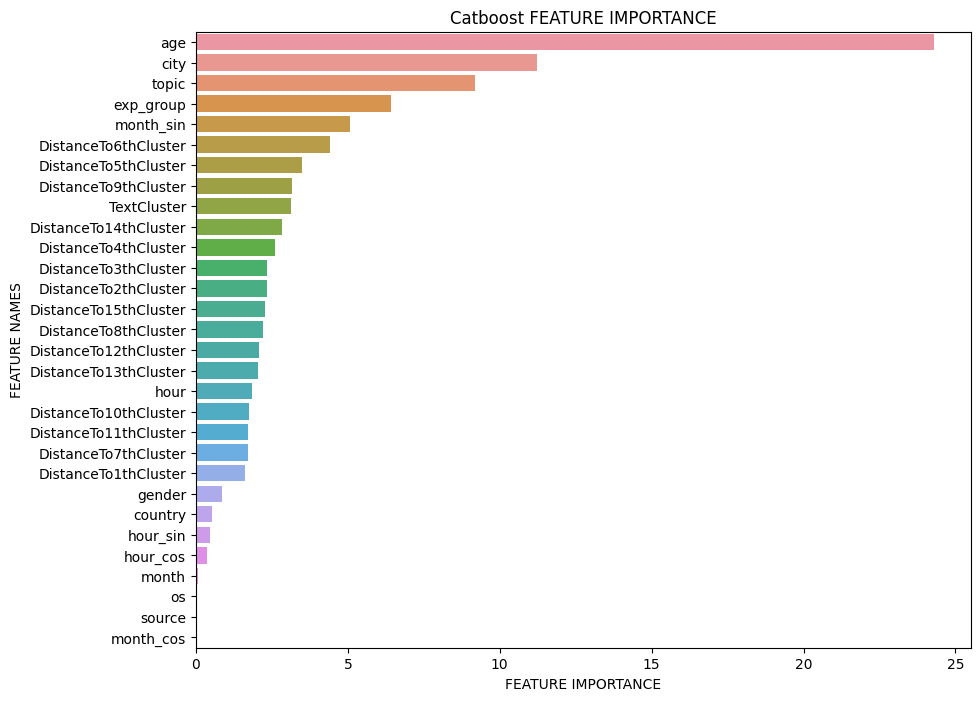

In [17]:
# Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def plot_feature_importance(importance, names, model_type):

    # Создадим массивы важности и названий признаков
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Создадим датафрейм из словаря
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Отсортируем по важности
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)

    # Определим размер графика
    plt.figure(figsize=(10, 8))
    # Нарисуем
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Добавим подписи
    plt.title(model_type + " FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")


plot_feature_importance(catboost.feature_importances_, X_train.columns, "Catboost")

In [18]:
# Сохраним модель
catboost.save_model("catboost_model_advanced", format="cbm")